### Міністерство освіти і науки України
#### Харківський національний університет радіоелектроніки

#### Кафедра системотехніки

#### Дисципліна: «Методи машинного навчання в системах проектування»

#### Лабораторна робота №1
#### «Робота з PyCaret»

#### Виконав
ст. гр. КНТ-21-4 Каменщиков Максим Олександрович

### Вхідні дані

The data are MC generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

| Variable  | Name    | Role       | Type                                              | Description | Units | Missing Values |
|-----------|---------|------------|---------------------------------------------------|-------------|-------|----------------|
| fLength   | Feature | Continuous | major axis of ellipse                             |             | mm    | no             |
| fWidth    | Feature | Continuous | minor axis of ellipse                             |             | mm    | no             |
| fSize     | Feature | Continuous | 10-log of sum of content of all pixels            |             | #phot | no             |
| fConc     | Feature | Continuous | ratio of sum of two highest pixels over fSize     |             |       | no             |
| fConc1    | Feature | Continuous | ratio of highest pixel over fSize                 |             |       | no             |
| fAsym     | Feature | Continuous | distance from highest pixel to center, projected onto major axis |             |       | no             |
| fM3Long   | Feature | Continuous | 3rd root of third moment along major axis         |             | mm    | no             |
| fM3Trans  | Feature | Continuous | 3rd root of third moment along minor axis         |             | mm    | no             |
| fAlpha    | Feature | Continuous | angle of major axis with vector to origin         |             | deg   | no             |
| fDist     | Feature | Continuous | distance from origin to center of ellipse         |             | mm    | no             |
| class     | Target  | Binary     | gamma (signal), hadron (background)               |             |       | no             |

*The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.*

Source: *https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope*

### Датасет

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 2500)
pd.set_option('display.max_colwidth', 2500)

In [3]:
from pycaret.datasets import get_data
dataset = get_data('telescope')

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
dataset.Class.value_counts()

Class
g    12332
h     6688
Name: count, dtype: int64

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConcl    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  Class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [6]:
# sample 5% of data to be used as unseen data
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

# print the revised shape
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

data_unseen.Class.value_counts()

Data for Modeling: (18069, 11)
Unseen Data For Predictions: (951, 11)


Class
g    609
h    342
Name: count, dtype: int64

### Підготовка даних

Датасет *telescope* з бібліотеки PyCaret – це симульовані дані, створені для моделювання реєстрації високоядерних гамма-частинок у наземному атмосферному Черенковському гамма-телескопі за допомогою методу візуалізації. Мета аналізу цього датасету – розрізняти сигнали, викликані гамма-квантами (корисний сигнал), від сигналів, спричинених адронами (фонова частка).

Таким чином, найбільш актуальне завдання для цього датасету – *класифікація*.

In [7]:
from pycaret import classification
s = classification.setup(data = data,
                         train_size = 0.9,
                         target = 'Class', 
                         session_id=123)


,Description,Value
0,Session id,123
1,Target,Class
2,Target type,Binary
3,Target mapping,"g: 0, h: 1"
4,Original data shape,"(18069, 11)"
5,Transformed data shape,"(18069, 11)"
6,Transformed train set shape,"(16262, 11)"
7,Transformed test set shape,"(1807, 11)"
8,Numeric features,10
9,Preprocess,True


In [8]:
# Отримання навчальних даних
classification.get_config('X_train')

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist
14629,163.441803,50.767700,3.0004,0.2449,0.1579,-57.667702,-127.088799,-47.442001,33.523300,175.086594
811,66.297897,25.235300,3.2718,0.1797,0.0939,19.545799,62.843800,12.729000,18.905001,239.686005
12541,216.886795,93.939499,3.6091,0.1137,0.0519,-222.340500,-152.383301,-111.991699,28.769600,166.264999
8456,103.021004,14.641800,2.8142,0.3819,0.1956,77.477600,96.572304,9.295300,19.430000,277.160004
8735,106.464996,21.824699,3.1457,0.4190,0.2127,58.472099,-84.155899,24.920601,21.012100,375.507996
...,...,...,...,...,...,...,...,...,...,...
8418,12.994500,11.074400,2.2516,0.7507,0.4398,-14.364300,6.484300,-10.240500,32.928001,205.419998
6638,115.602997,22.154100,3.2964,0.1592,0.0806,-75.577301,44.780602,19.889601,49.379002,106.139999
1540,34.835899,16.298700,2.5746,0.4261,0.2543,10.718300,-17.273600,9.087200,2.605500,237.414001
7586,44.988602,24.394300,3.0650,0.2213,0.1261,-10.309600,39.096100,15.220000,6.065000,157.056000


### Підготовка та відбір моделей

In [9]:
classification.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessClassifier,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [10]:
best = classification.compare_models(exclude=['nb'], sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8816,0.9352,0.8816,0.8818,0.8794,0.7319,0.7362,0.2290
rf,Random Forest Classifier,0.8793,0.9350,0.8793,0.8793,0.8771,0.7269,0.7310,1.3460
et,Extra Trees Classifier,0.8767,0.9345,0.8767,0.8778,0.8738,0.7189,0.7254,0.4810
gbc,Gradient Boosting Classifier,0.8697,0.9231,0.8697,0.8709,0.8664,0.7021,0.7093,1.3370
ada,Ada Boost Classifier,0.8398,0.8947,0.8398,0.8383,0.8369,0.6375,0.6413,0.3300
dt,Decision Tree Classifier,0.8187,0.8022,0.8187,0.8193,0.8189,0.6031,0.6033,0.1090
knn,K Neighbors Classifier,0.8061,0.8408,0.8061,0.8055,0.7981,0.5480,0.5604,0.5930
lr,Logistic Regression,0.7897,0.8389,0.7897,0.7864,0.7824,0.5134,0.5222,1.0180
lda,Linear Discriminant Analysis,0.7834,0.8382,0.7834,0.7808,0.7737,0.4930,0.5058,0.0390
ridge,Ridge Classifier,0.7831,0.8383,0.7831,0.7810,0.7728,0.4907,0.5048,0.0850


### Створення моделі

In [11]:
lightgbm = classification.create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8912,0.9401,0.8912,0.8912,0.8895,0.7548,0.7581
1,0.8783,0.9315,0.8783,0.8773,0.8770,0.7278,0.7293
2,0.8942,0.9385,0.8942,0.8944,0.8925,0.7614,0.7648
3,0.8770,0.9378,0.8770,0.8792,0.8736,0.7178,0.7263
4,0.8708,0.9280,0.8708,0.8702,0.8687,0.7084,0.7118
5,0.8782,0.9325,0.8782,0.8783,0.8759,0.7239,0.7285
6,0.8819,0.9340,0.8819,0.8822,0.8796,0.7323,0.7369
7,0.8721,0.9339,0.8721,0.8732,0.8688,0.7075,0.7146
8,0.8807,0.9330,0.8807,0.8803,0.8788,0.7308,0.7341


In [12]:
tuned_model = classification.tune_model(lightgbm)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:26:41
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8900,0.9395,0.8900,0.8894,0.8887,0.7535,0.7555
1,0.8709,0.9258,0.8709,0.8698,0.8697,0.7118,0.7130
2,0.8831,0.9376,0.8831,0.8827,0.8815,0.7370,0.7398
3,0.8801,0.9343,0.8801,0.8816,0.8771,0.7259,0.7331
4,0.8678,0.9266,0.8678,0.8674,0.8652,0.7003,0.7046
5,0.8733,0.9307,0.8733,0.8727,0.8712,0.7139,0.7173
6,0.8758,0.9331,0.8758,0.8756,0.8735,0.7188,0.7229
7,0.8665,0.9287,0.8665,0.8665,0.8637,0.6965,0.7017
8,0.8727,0.9321,0.8727,0.8721,0.8705,0.7124,0.7159


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


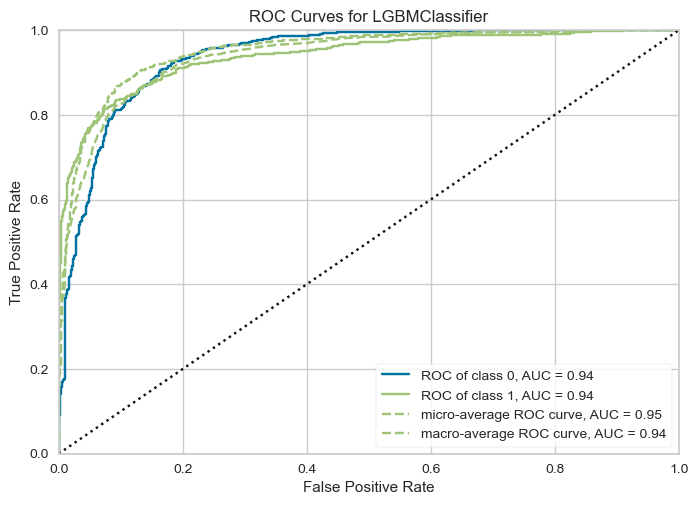

In [13]:
classification.plot_model(lightgbm, plot = 'auc')

Вісь X - False Positive Rate (FPR) (помилки 1-го роду) показує, як часто модель помилково відносить фонові події до позитивного класу (сигнал).

Вісь Y - True Positive Rate (TPR) показує, наскільки добре модель знаходить позитивні приклади.

*Проста точність класифікації не має значення для цих даних, оскільки класифікація фонової події як сигнальної є гіршою, ніж класифікація сигнальної події як фонової. Для порівняння різних класифікаторів слід використовувати ROC-криву. Відповідними точками на цій кривій є ті, де ймовірність прийняття фонової події за сигнал є нижчою за один з наступних порогів: 0.01, 0.02, 0.05, 0.1, 0.2 залежно від необхідної якості вибірки прийнятих подій для різних експериментів*.

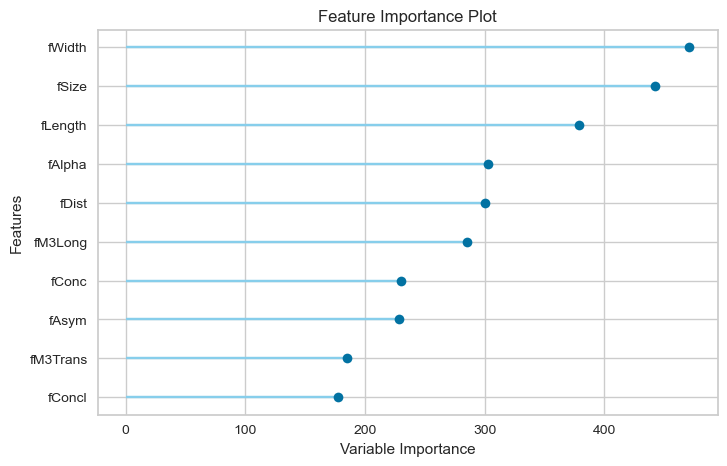

In [14]:
classification.plot_model(lightgbm, plot='feature_all')

На цьому графіку відображено важливість змінних на результат

### Тестування

In [13]:
classification.predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8854,0.9390,0.8854,0.8851,0.8837,0.7421,0.7450


,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class,prediction_label,prediction_score
7747,29.950800,15.454900,2.6405,0.3547,0.1888,4.531900,15.161600,7.499500,23.961700,133.095993,g,g,0.9309
14989,91.467300,26.383900,2.8337,0.2573,0.1386,21.299000,91.342201,22.652000,51.757900,225.130096,h,h,0.9478
7367,53.487202,22.017401,2.9317,0.2153,0.1106,58.172001,51.078999,-15.706400,16.456900,168.167007,g,g,0.9563
13403,28.045300,23.997601,2.8624,0.3267,0.2080,12.058200,-20.750601,-14.546600,4.978600,132.009003,g,g,0.9332
9478,112.771599,8.415200,2.4899,0.6626,0.3489,-150.469803,93.162903,-12.610800,65.626099,220.881393,h,h,0.9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,41.147301,14.553300,2.8178,0.2374,0.1028,30.431499,-10.329200,-4.115300,82.264702,147.108200,h,h,0.9375
15412,26.837200,11.837400,2.6075,0.4815,0.2951,9.225000,22.430401,-9.499400,38.088001,221.233002,h,h,0.8432
413,166.072998,132.014999,5.0118,0.0162,0.0086,-257.947998,84.351898,41.515099,37.370998,162.483994,h,h,0.9603
15715,12.688400,11.688600,2.0737,0.7004,0.3924,15.769800,-9.602000,6.251300,63.885700,85.734802,g,g,0.9085


In [ ]:
# finalize model
final_lightgbm = classification.finalize_model(lightgbm)
# print final model parameters
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['fLength', 'fWidth', 'fSize',
                                             'fConc', 'fConcl', 'fAsym',
                                             'fM3Long', 'fM3Trans', 'fAlpha',
                                             'fDist'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              cop...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_

In [15]:
classification.predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9292,0.9722,0.9292,0.9296,0.9283,0.8413,0.8435


,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class,prediction_label,prediction_score
7747,29.950800,15.454900,2.6405,0.3547,0.1888,4.531900,15.161600,7.499500,23.961700,133.095993,g,g,0.9293
14989,91.467300,26.383900,2.8337,0.2573,0.1386,21.299000,91.342201,22.652000,51.757900,225.130096,h,h,0.9381
7367,53.487202,22.017401,2.9317,0.2153,0.1106,58.172001,51.078999,-15.706400,16.456900,168.167007,g,g,0.9436
13403,28.045300,23.997601,2.8624,0.3267,0.2080,12.058200,-20.750601,-14.546600,4.978600,132.009003,g,g,0.9329
9478,112.771599,8.415200,2.4899,0.6626,0.3489,-150.469803,93.162903,-12.610800,65.626099,220.881393,h,h,0.9561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,41.147301,14.553300,2.8178,0.2374,0.1028,30.431499,-10.329200,-4.115300,82.264702,147.108200,h,h,0.9535
15412,26.837200,11.837400,2.6075,0.4815,0.2951,9.225000,22.430401,-9.499400,38.088001,221.233002,h,h,0.7752
413,166.072998,132.014999,5.0118,0.0162,0.0086,-257.947998,84.351898,41.515099,37.370998,162.483994,h,h,0.9550
15715,12.688400,11.688600,2.0737,0.7004,0.3924,15.769800,-9.602000,6.251300,63.885700,85.734802,g,g,0.8918


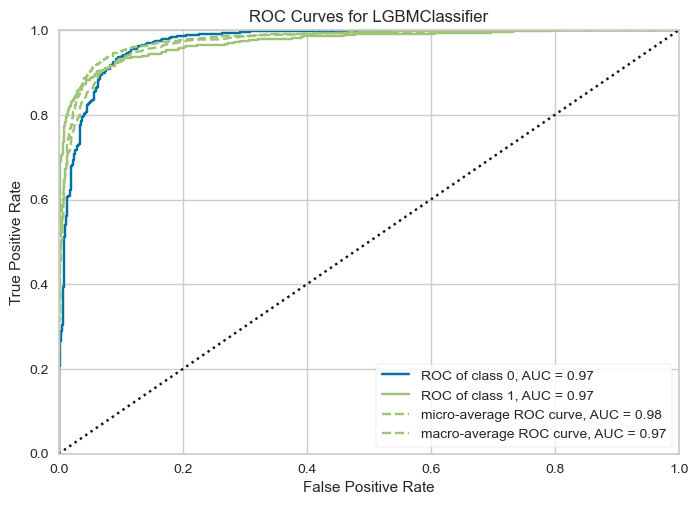

In [42]:
classification.plot_model(final_lightgbm, plot = 'auc')

In [16]:
unseen_predictions = classification.predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8833,0.9385,0.8833,0.8829,0.8818,0.7408,0.7433


,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class,prediction_label,prediction_score
0,51.624001,21.150200,2.9085,0.2420,0.1340,50.876099,43.188702,9.8145,3.6130,238.098007,g,g,0.9741
1,73.626297,35.582001,3.4533,0.2493,0.1333,-48.037701,42.611900,-26.2742,4.4710,372.316986,g,g,0.9382
2,96.857803,39.475498,3.9903,0.1204,0.0679,-59.036900,66.029099,-26.4310,3.8107,340.996002,g,g,0.9870
3,34.950199,16.012100,3.0663,0.2970,0.1644,-12.519200,11.141300,-7.5776,17.6684,201.404007,g,g,0.8992
4,73.254700,19.555201,2.5545,0.3570,0.1939,-44.125801,34.593899,16.6915,23.1490,282.615997,g,h,0.5856


In [38]:
unseen_predictions[unseen_predictions['prediction_score'] > 0.99]

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class,prediction_label,prediction_score
13,86.534599,40.620098,4.1111,0.0915,0.0458,35.889900,74.545601,25.140600,4.815200,219.069000,g,g,0.9936
20,88.556198,23.465700,3.6856,0.1452,0.0851,74.444099,72.969398,10.424100,0.879400,230.343994,g,g,0.9940
21,77.814102,26.512199,3.7987,0.1644,0.0897,37.005100,65.720703,14.235300,2.712000,218.662003,g,g,0.9956
30,92.633202,30.140400,3.6898,0.2141,0.1278,-20.768200,71.701500,14.493400,0.123000,340.838989,g,g,0.9948
39,63.965500,26.658400,3.7121,0.1744,0.0987,46.617500,55.628799,-13.085800,5.761100,228.000000,g,g,0.9936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,106.456001,83.516800,4.0233,0.1101,0.0573,-102.782997,-73.835899,47.377499,67.316002,365.015991,h,h,0.9968
940,32.552799,4.695700,2.5419,0.6565,0.3365,-14.248600,17.707001,10.059900,49.757099,216.474503,h,h,0.9941
942,131.863998,77.813103,3.1889,0.3346,0.2049,-47.990398,-176.335007,-60.048901,85.081001,271.402008,h,h,0.9974
943,160.138000,49.078300,3.4597,0.1478,0.0925,-163.356995,-48.228901,-48.352501,70.412003,251.778000,h,h,0.9929


### Збереження моделі

In [19]:
classification.save_model(final_lightgbm,'telescope_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['fLength', 'fWidth', 'fSize',
                                              'fConc', 'fConcl', 'fAsym',
                                              'fM3Long', 'fM3Trans', 'fAlpha',
                                              'fDist'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               cop...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                     